# Swap Default PySAM WindPower for FLORIS Example
---
In this example, we will show how to change the default [PySAM WindPower](https://nrel-pysam.readthedocs.io/en/main/modules/Windpower.html) wind model to the [FLORIS](https://www.nrel.gov/wind/floris.html) wind model. FLORIS is capable of modeling different steady-state wind wake models and complex turbine interactions. This example is meant to illustrate how the inputs to HOPP change, although it's important to note that FLORIS offers additional adjustable parameters on its side.

### Import Required Modules
We start by importing the necessary modules and setting up our working environment.

In [1]:
from hopp.simulation import HoppInterface

/Users/cirmas/workspace/HOPP/examples/workshop/log/hybrid_systems_2023-10-23T16.09.34.664416.log


### Create the Simulation Model
Create an instance of the `HoppInterface` class by providing the YAML configuration file.

A key difference when employing FLORIS instead of PySAM as the wind system model is found within the `wind` section under `technologies`.

Apart from setting the `num_turbines` and `turbine_rating_kw`, as demonstrated in prior examples, you must also introduce these parameters to configure the FLORIS model:

    model_name: floris
    timestep: [0, 8760]
    floris_config: inputs/floris/gch.yaml

**NOTE**: When you create the instance you should see a print out that says `FLORIS is the system model...`

In [2]:
hi = HoppInterface("./inputs/05-floris-wake-model.yaml")

FLORIS is the system model...


### Run the Simulation
Simulate the hybrid renewable energy system for a specified number of years (in this case, 25 years).

In [3]:
hi.simulate(25)

Simulating wind farm output in FLORIS...
Wind annual energy:  71702641.3705228


### Retrieve and Display Results
Access the simulation results, including annual energies, capacity factors and net present values (NPVs), and print them to the console.

In [4]:
hybrid_plant = hi.system
annual_energies = hybrid_plant.annual_energies
npvs = hybrid_plant.net_present_values
cf = hybrid_plant.capacity_factors

wind_installed_cost = hybrid_plant.wind.total_installed_cost
solar_installed_cost = hybrid_plant.pv.total_installed_cost
hybrid_installed_cost = hybrid_plant.grid.total_installed_cost

print("Wind Installed Cost: {}".format(wind_installed_cost))
print("Solar Installed Cost: {}".format(solar_installed_cost))
print("Hybrid Installed Cost: {}".format(hybrid_installed_cost))

print("Wind NPV: {}".format(hybrid_plant.net_present_values.wind))
print("Solar NPV: {}".format(hybrid_plant.net_present_values.pv))
print("Hybrid NPV: {}".format(hybrid_plant.net_present_values.hybrid))

print(annual_energies)
print(cf)
print(npvs)

Wind Installed Cost: 29080000.0
Solar Installed Cost: 48000000.0
Hybrid Installed Cost: 77080000.0
Wind NPV: 0
Solar NPV: -35042037.04939877
Hybrid NPV: -58187428.29521625
{"pv": 104053614.17593749, "wind": 71702641.3705228, "hybrid": 175298576.2259878}
{"pv": 23.75653291688071, "wind": 40.92616516582351, "hybrid": 28.662142130864364}
{"pv": -35042037.04939877, "wind": 0, "hybrid": -58187428.29521625}


### Visualize Turbine Wakes using FLORIS (Optional) 

Optionally, you can visualize the wakes from the turbines using plotting tools from FLORIS.

 Additional instructions for generating wake plots from floris can be found in [FLORIS plotting example](https://github.com/NREL/floris/blob/main/examples/02_visualizations.py)

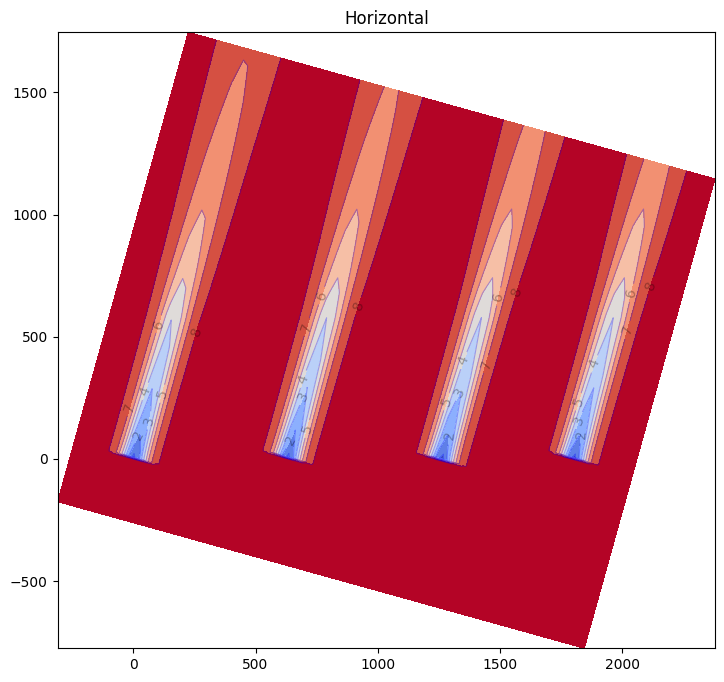

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from floris.tools import FlorisInterface
import floris.tools.visualization as wakeviz

site = hybrid_plant.site

wind_speed = [W[2] for W in site.wind_resource._data['data']]
wind_dirs = [W[3] for W in site.wind_resource._data['data']]

fi = FlorisInterface("inputs/floris/gch.yaml")
fi.reinitialize(wind_speeds=[np.round(np.average(wind_speed), decimals=3)])
fi.reinitialize(wind_directions=[np.round(np.median(wind_dirs), decimals=2)])
horizontal_plane = fi.calculate_horizontal_plane(
    x_resolution=200,
    y_resolution=100,
    height=90.0,
    # yaw_angles=np.array([[[25.,0.,0.,0.]]]),
)

fig, ax_list = plt.subplots(1, 1, figsize=(10, 8))

wakeviz.visualize_cut_plane(horizontal_plane, ax=ax_list, title="Horizontal")

wakeviz.show_plots()